In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

In [3]:
#to convert a geographic point into a circular buffer with radius in meters.

from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

# def buffer_in_meters(lng, lat, radius):
def buffer_in_meters(pt_latlng, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
#     pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [4]:
gdf_county = gpd.read_file("county.zip")

<AxesSubplot:>

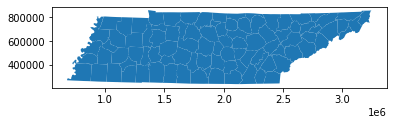

In [5]:
gdf_county.plot()

In [6]:
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]

In [7]:
gdf_dav.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
30,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1725320.674 734952.517, 1725410.826 ..."
49,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1814456.873 657102.349, 1813945.726 ..."


In [8]:
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds

array([1656664.95403244,  595562.71399883, 1816136.87059501,
        755249.86127501])

In [10]:
length = 5280
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")
# grid.plot()

32
32


<AxesSubplot:>

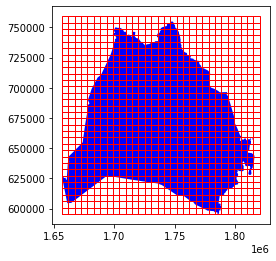

In [11]:
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')

In [12]:
df_incidents = pd.read_json("incident.json")
gdf_incidents2 = gpd.GeoDataFrame(
    df_incidents, geometry=gpd.points_from_xy(df_incidents.longitude, df_incidents.latitude))
incidents = gdf_incidents2.set_crs("EPSG:4326")
incidents.head()

,ID_Original,latitude,longitude,emdCardNumber,time_utc,fireZone,time,time_local,response_time_sec,year,month,day,day_of_week,weekend_or_not,hour,window,geometry,Incident_ID,Dist_to_Seg,XDSegID
0,ObjectId(59d3a81908f47311c891f8e2),36.037228,-86.783243,29B5,1483257569507,10,1483257569507,1483235969507,268.0,2017,1,1,6,1,1,23,POINT (-86.78324 36.03723),10,13.550370,1.524394e+09
1,ObjectId(59d3a81908f47311c891f8e6),36.037414,-86.786572,29D2P,1483259455000,10,1483259455000,1483237855000,512.0,2017,1,1,6,1,2,30,POINT (-86.78657 36.03741),11,3.663952,1.524356e+09
2,ObjectId(59d3a81a08f47311c891f8ef),36.217663,-86.808699,29D1H,1483263310000,25,1483263310000,1483241710000,271.0,2017,1,1,6,1,3,43,POINT (-86.80870 36.21766),12,NaN,NaN
3,ObjectId(59d3a81a08f47311c891f8f9),36.057790,-86.739728,29D8V,1483266571867,10,1483266571867,1483244971867,366.0,2017,1,1,6,1,4,53,POINT (-86.73973 36.05779),13,NaN,NaN
4,ObjectId(59d3a81a08f47311c891f904),36.039221,-86.602785,29A2V,1483268953000,33,1483268953000,1483247353000,447.0,2017,1,1,6,1,5,61,POINT (-86.60279 36.03922),14,3.171782,4.496208e+08


In [12]:
# dav_grids = gpd.overlay(gdf_dav, grid, how='intersection')
# dav_grids.plot()

In [13]:
grids = grid.set_crs("EPSG:2274")
grids.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Tennessee - counties of Anderson; Bedford; Benton; Bledsoe; Blount; Bradley; Campbell; Cannon; Carroll; Carter; Cheatham; Chester; Claiborne; Clay; Cocke; Coffee; Crockett; Cumberland; Davidson; De Kalb; Decatur; Dickson; Dyer; Fayette; Fentress; Franklin; Gibson; Giles; Grainger; Greene; Grundy; Hamblen; Hamilton; Hancock; Hardeman; Hardin; Hawkins; Haywood; Henderson; Henry; Hickman; Houston; Humphreys; Jackson; Jefferson; Johnson; Knox; Lake; Lauderdale; Lawrence; Lewis; Lincoln; Loudon; Macon; Madison; Marion; Marshall; Maury; McMinn; McNairy; Meigs; Monroe; Montgomery; Moore; Morgan; Obion; Overton; Perry; Pickett; Polk; Putnam; Rhea; Roane; Robertson; Rutherford; Scott; Sequatchie; Sevier; Shelby; Smith; Stewart; Sullivan; Sumner; Tipton; Trousdale; Unicoi; Union; Van Buren; Warren; Wa

In [14]:
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')
# dav_grids.plot(figsize=(10, 10))
# plt.show()
# dav_grids.shape

In [15]:
dav_grids['grid_num'] = np.arange(len(dav_grids))

In [16]:
dav_grids

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry,grid_num
0,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1661067.007 604445.851, 1660729.383 ...",0
1,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1660556.754 606980.106, 1660160.039 ...",1
2,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1659182.784 613788.323, 1658655.633 ...",2
3,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1658154.847 618932.019, 1657629.924 ...",3
4,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1657456.311 622368.268, 1657102.590 ...",4
...,...,...,...,...,...,...,...,...,...
599,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1810293.363 657484.514, 1810964.959 ...",599
600,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1813945.726 657150.905, 1814146.610 ...",600
601,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1815545.748 637646.651, 1815064.954 ...",601
602,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1815815.066 640405.917, 1815560.980 ...",602


In [17]:
dav_grids2 = dav_grids.to_crs("EPSG:4326")

In [18]:
dav_grids2

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry,grid_num
0,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.03922 35.98939, -87.04042 35.993...",0
1,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04103 35.99633, -87.04244 36.001...",1
2,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04592 36.01500, -87.04780 36.022...",2
3,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04958 36.02909, -87.05145 36.036...",3
4,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.05207 36.03851, -87.05333 36.043...",4
...,...,...,...,...,...,...,...,...,...
599,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.53578 36.13838, -86.53350 36.137...",599
600,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((-86.52341 36.13752, -86.52274 36.140...",600
601,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51764 36.08397, -86.51927 36.084...",601
602,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51678 36.09155, -86.51759 36.084...",602


In [19]:
joined2 = incidents.sjoin(dav_grids2, how="right")
# joined2[joined2["grid_num"]==299]

In [20]:
# joined2['row_num'] = np.arange(len(joined2))
joined2['grid_num'].nunique()
joined2.shape

(29745, 29)

In [21]:
inc_grids = pd.Series.tolist(joined2.grid_num.value_counts())


In [23]:
inc_index = list(joined2.grid_num.value_counts().index)
# inc_index

In [24]:
dav_grids2["no_of_incidents"] = 0

for i in range(len(inc_index)):
#     print("i",i)
    for j in range(dav_grids2.shape[0]):
#         print(j, joined["row_num"][j], inc_index[i], inc_grids[i])
        if (dav_grids2["grid_num"][j] == inc_index[i]):
            dav_grids2["no_of_incidents"][j]= inc_grids[i]
        
        

C:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

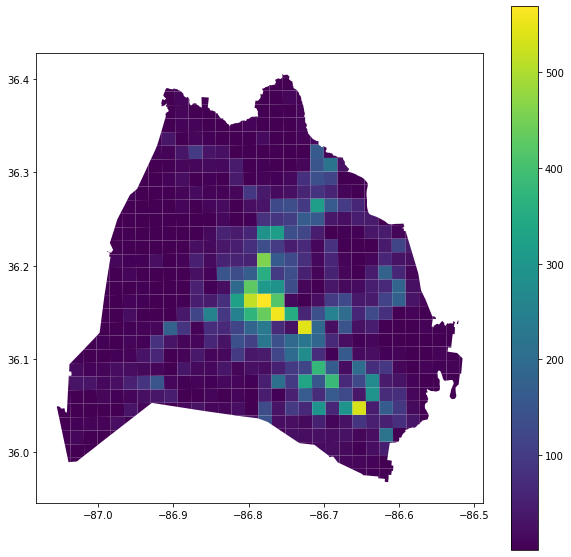

In [25]:
dav_grids2.plot(column='no_of_incidents', legend=True, figsize=(10, 10))

In [26]:
import math
start_time = 1483250400000 # 2017-01-01 00:00:00
# start_time = g_dav.time_local.min()
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
# end_time = g_dav.time_local.max()

curr_time = start_time/1000
# print(start_time/1000)

incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000))]
incidents_per_day = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/86400))]
incidents_per_4hrs = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/14400)+10)]
print(int(math.ceil((end_time - start_time)/1000)/14400))

9126


In [28]:
joined3 = joined2
joined3.dropna(subset = ["time_local"], inplace=True)

In [29]:
incidents_mat = [np.arange(len(incidents_per_month))]

start_time = 1483250400000 # 2017-01-01 00:00:00
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
duration = int(math.ceil((end_time - start_time)/1000))
for k in range(dav_grids2.grid_num.iloc[-1]+1):
    g_dav = joined3[joined3["grid_num"]==k]
#     print(g_dav["grid_num"])
    
    curr_time = start_time/1000
    incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000))]
    incidents_per_day = [0 for i in range(int(duration/86400))]
    incidents_per_4hrs = [0 for i in range(int(duration/14400)+10)]
    counter_4hrs = 0

    for i in range(g_dav.shape[0]):
        inc_time = (g_dav.time_local.iloc[i])/1000 #incident time #incidents.time_local
        while True:
            limit_time = curr_time +14400
    #         print(inc_time-limit_time, inc_time-curr_time)
            if (inc_time < limit_time):
                incidents_per_4hrs[counter_4hrs]+=1
#                 print("found")
                break

            else:
                curr_time = limit_time
                counter_4hrs += 1
                
    sum_day = incidents_per_4hrs[0]
    counter_day = 0
    for i in range(1, counter_4hrs+1): 
        if i%6 == 0:
            incidents_per_day[counter_day] = sum_day
            counter_day+=1
            sum_day = 0
        sum_day += incidents_per_4hrs[i]
#     print(k)
    if (k == 299):
        print(sum(incidents_per_day))
        
    sum_month = incidents_per_day[0]
    counter_month = 0
    for i in range(1, counter_day): 
        if i%30 == 0:
            incidents_per_month[counter_month] = sum_month
            counter_month+=1
            sum_month = 0
        sum_month += incidents_per_day[i]
#         print(sum_month)
        
    incidents_mat.append(incidents_per_month)

568


In [30]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [37]:
arr_grids = pd.Series.tolist(dav_grids2.grid_num)
arr_incs = pd.Series.tolist(dav_grids2.no_of_incidents)
# print(arr_grids)

In [41]:
dav_grids_dist = dav_grids
dist_mat = [[] for i in range(dav_grids_dist.grid_num.iloc[-1]+1)]

for i in range(0, 604):
  p1 = dav_grids_dist.geometry.iloc[i].centroid
  for j in range(dav_grids_dist.grid_num.iloc[-1]+1):
    p2 = dav_grids_dist.geometry.iloc[j].centroid
    dist_mat[i].append(round(p1.distance(p2), 2))

# print(dist_mat)

In [42]:
from docplex.mp.model import Model

tm = Model(name='distribution')

sheds = arr_grids
grids = arr_grids
max_shedsP = 3
demand = arr_incs
distance = dist_mat
shed_loc = tm.binary_var_list(len(sheds), 0, 1, "shed")
# open_loc = {(i): tm.binary_var(name='loc_{0}'.format(s)) for s in sheds}
# print(open_loc)
assign = [[tm.binary_var("assign_{0}_{1}".format(i, j)) for j in range(len(grids))]  for i in range(len(sheds))]
# assign = {(i,j): tm.binary_var(name='assign_{0}_{1}'.format(s,g)) for s in sheds for g in grids}
# print(assign)
# each arc comes with a cost. Minimize all costed flows

tm.print_information()

for g in grids:
    tm.add_constraint(tm.sum(assign[s][g] for s in sheds) == 1)
    
tm.add_constraint(tm.sum(shed_loc[s] for s in sheds) == max_shedsP)
    
for s in sheds:
    for g in grids:
        tm.add_constraint(assign[s][g] <= shed_loc[s])
        
tm.minimize(tm.sum(distance[s][g]*demand[g]*assign[s][g] for s in sheds for g in grids))
url = None
key = None
tms = tm.solve(url=url, key=key)
assert tms
tms.display()

Model: distribution
 - number of variables: 365420
   - binary=365420, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP
solution for: distribution
objective: 561438830.440
shed_274 = 1
shed_390 = 1
shed_432 = 1
assign_274_0 = 1
assign_274_1 = 1
assign_274_2 = 1
assign_274_3 = 1
assign_274_4 = 1
assign_274_5 = 1
assign_274_6 = 1
assign_274_7 = 1
assign_274_8 = 1
assign_274_9 = 1
assign_274_10 = 1
assign_274_11 = 1
assign_274_12 = 1
assign_274_13 = 1
assign_274_14 = 1
assign_274_15 = 1
assign_274_16 = 1
assign_274_17 = 1
assign_274_18 = 1
assign_274_19 = 1
assign_274_20 = 1
assign_274_21 = 1
assign_274_22 = 1
assign_274_23 = 1
assign_274_24 = 1
assign_274_25 = 1
assign_274_26 = 1
assign_274_27 = 1
assign_274_28 = 1
assign_274_29 = 1
assign_274_30 = 1
assign_274_31 = 1
assign_274_32 = 1
assign_274_33 = 1
assign_274_34 = 1
assign_274_35 = 1
assign_274_36 = 1
assign_274_37 = 1
assign_274_38 = 1
assign_274_3

In [ ]:
locs = []
assignments  = [[], [], []]
count = 0
for i in range(len(shed_loc)):
    if (shed_loc[i].solution_value == 1):
        locs.append(i)
        for j in range(len(grids)):
            if (assign[i][j].solution_value == 1):
                assignments[count].append(j) 
        count+=1
    

<AxesSubplot:>

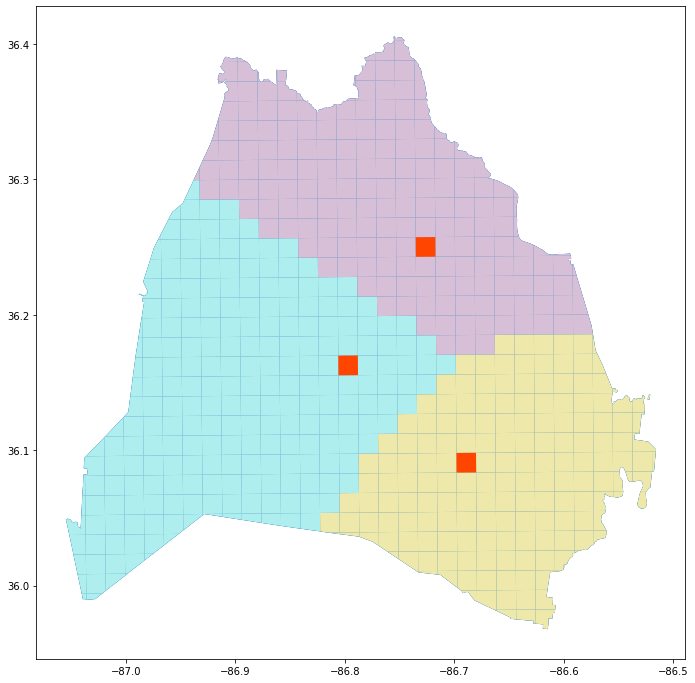

In [45]:
dav_grids3 = dav_grids2
dax = dav_grids3.plot(figsize=(12, 12))
dav_grids3.plot(ax = dax)
for i in assignments[0]:
    dav_grids3[dav_grids3.grid_num == i].plot(ax = dax, color='paleturquoise')
for i in assignments[1]:
    dav_grids3[dav_grids3.grid_num == i].plot(ax = dax, color='thistle')
for i in assignments[2]:
    dav_grids3[dav_grids3.grid_num == i].plot(ax = dax, color='palegoldenrod')
dav_grids3[dav_grids3.grid_num == locs[0]].plot(ax = dax, color='orangered')
dav_grids3[dav_grids3.grid_num == locs[1]].plot(ax = dax, color='orangered')
dav_grids3[dav_grids3.grid_num == locs[2]].plot(ax = dax, color='orangered')